## Necessary conditions for Max Clique 
### Install pyQUBO from Recruit Communications Co. Ltd.
    pip install pyqubo
### Install openJij from Jij Inc.  (startup from Tohoku University)
    pip install openjij

### Add networkx for dealing with graph theory

        pip install networkx

# Solve Max Clique

### import pyQUBO, openJij, numpy and matplotlib

In [1]:
from pyqubo  import Array,Constraint, Placeholder
import openjij as jij
import numpy as np
import matplotlib.pyplot as plt

Array, Constrains and Placeholders are convenient classes from pyQUBO

### import networkx

In [2]:
import networkx as nx

### Prepare some graph

In [3]:
nodes = [0, 1, 2, 3, 4, 5]
edges = [
    (0, 1), (1, 2), (2, 4), (1, 3),
    (3, 4), (4, 5), (3, 5)
    ]

### Set nodes and edges on Graph G

In [4]:
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

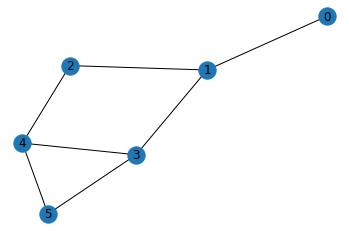

In [5]:
nx.draw_networkx(G)
plt.axis("off")
plt.show()

### Prepare binary variables

In [6]:
N = 6
K = 3
vartype = "BINARY"
q = Array.create("q",shape=N,vartype=vartype)

"q" is name of variables  
shape specifies the shape of variables as vector, matrix, or...  
vartype selects -1 or 1 by "SPIN" and 0 or 1by "BINARY"

In [7]:
print(q)

Array([Binary(q[0]), Binary(q[1]), Binary(q[2]), Binary(q[3]), Binary(q[4]), Binary(q[5])])


### Define cost function

In [34]:
E1 = Constraint(0.5*(np.sum(q)-K)**2,"K")

In [35]:
E2 = 0
for e in edges:
    E2 += - q[e[0]]*q[e[1]]
E2 += 0.5*K*(K-1)

In [36]:
Lam = Placeholder('Lam')
E_cost = Lam*E1+E2

### Compile the cost function

In [37]:
model = E_cost.compile()

### Get qubo matrix

In [38]:
feed_dict = {'Lam': 5.0}
Q, offset = model.to_qubo(feed_dict=feed_dict)

### Prepare simulation of quantum annealing

In [39]:
#simulated quantum annealing
sampler = jij.SQASampler(beta=10.0, gamma=1.0, trotter=4, num_sweeps=100)
#simulated annealing
#sampler = jij.SASampler(num_sweeps=1000)

This is done by quantum Monte-Carlo simulation  
gamma = strength of quantum fluctuation  
trotter = Trotter number  
num_sweeps = length of MCS

### Let's simulate quantum annealing

In [40]:
response = sampler.sample_qubo(Q,num_reads=100)

### Show results

In [41]:
print(response)

   q[0] q[1] q[2] q[3] q[4] q[5] energy num_oc.
0     0    0    0    1    1    1  -25.5       1
1     0    0    0    1    1    1  -25.5       1
2     0    0    0    1    1    1  -25.5       1
3     0    0    0    1    1    1  -25.5       1
4     0    0    0    1    1    1  -25.5       1
6     0    0    0    1    1    1  -25.5       1
8     0    0    0    1    1    1  -25.5       1
9     0    0    0    1    1    1  -25.5       1
10    0    0    0    1    1    1  -25.5       1
13    0    0    0    1    1    1  -25.5       1
15    0    0    0    1    1    1  -25.5       1
16    0    0    0    1    1    1  -25.5       1
17    0    0    0    1    1    1  -25.5       1
21    0    0    0    1    1    1  -25.5       1
22    0    0    0    1    1    1  -25.5       1
23    0    0    0    1    1    1  -25.5       1
24    0    0    0    1    1    1  -25.5       1
25    0    0    0    1    1    1  -25.5       1
28    0    0    0    1    1    1  -25.5       1
29    0    0    0    1    1    1  -25.5 

### minimum sample

In [42]:
response.record["sample"]

array([[0, 0, 0, 1, 1, 1],
       [0, 0, 0, 1, 1, 1],
       [0, 0, 0, 1, 1, 1],
       [0, 0, 0, 1, 1, 1],
       [0, 0, 0, 1, 1, 1],
       [1, 1, 1, 0, 0, 0],
       [0, 0, 0, 1, 1, 1],
       [0, 1, 1, 0, 1, 0],
       [0, 0, 0, 1, 1, 1],
       [0, 0, 0, 1, 1, 1],
       [0, 0, 0, 1, 1, 1],
       [1, 1, 1, 0, 0, 0],
       [0, 1, 1, 1, 0, 0],
       [0, 0, 0, 1, 1, 1],
       [0, 1, 1, 0, 1, 0],
       [0, 0, 0, 1, 1, 1],
       [0, 0, 0, 1, 1, 1],
       [0, 0, 0, 1, 1, 1],
       [0, 1, 0, 1, 1, 0],
       [0, 0, 1, 0, 1, 1],
       [0, 1, 1, 0, 1, 0],
       [0, 0, 0, 1, 1, 1],
       [0, 0, 0, 1, 1, 1],
       [0, 0, 0, 1, 1, 1],
       [0, 0, 0, 1, 1, 1],
       [0, 0, 0, 1, 1, 1],
       [0, 1, 0, 1, 1, 0],
       [0, 1, 0, 1, 1, 0],
       [0, 0, 0, 1, 1, 1],
       [0, 0, 0, 1, 1, 1],
       [0, 1, 0, 1, 1, 0],
       [0, 0, 0, 1, 1, 1],
       [0, 0, 0, 1, 1, 1],
       [0, 0, 0, 1, 1, 1],
       [0, 1, 0, 1, 1, 0],
       [0, 0, 0, 1, 1, 1],
       [0, 0, 0, 1, 1, 1],
 

### show resulting graph

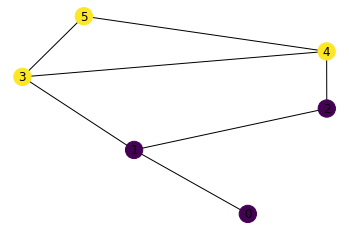

In [58]:
spin = response.record["sample"][0]
node_colors = [spin[node]>0 for node in G.nodes()]

nx.draw_networkx(G,node_color=node_colors)
plt.axis("off")
plt.show()